# RECOMMENDER SYSTEM - MOVIES

This project will use the MovieLens Dataset, downloaded from the Kaggle platform. 

https://inclass.kaggle.com/c/movie-recommendation

## Data description 
The dataset is composed of 3 main files : 
- users data [UserID::Gender::Age::Occupation::Zip-code]
- movies data [MovieID::Title::Genres]
- rating data [UserID::MovieID::Rating::Timestamp]



## Recommender system description
The recommender system will use the MovieLens Data to recommend movies to users based on their previous interest. 

It is required that the recommender system has 2 endpoints : 
- addData(userId, itemId): indicates that userId was previously interested in itemId
- predictInterests(userId): should return a list of 5 itemIds that may be interesting to this userId



## Modeling
As users have rated movies, we can learn a predictor that will predict, for each user, the rating of all movies based on each user past movie rating. 
Our recommender system will then, for each user, recommend movies that have the best rating. 

If we could predict with 100% accuracy a movie rating based on past user rating, we could guess what movies would have the best rating for each user, hence recommend what a user likes. 

Our input matrix $X$ will then be : 
$$X = X_{users},X_{movies}$$
with $$X_{users} = user_1,\dots,user_n$$
$$X_{movies} = movie_1,\dots,movie_p$$

And our predicted variable $Y$, the corresponding {user,movie} rating : 
$$Y = rating_1,\dots,rating_k$$
with $$n=numberOfUsers$$
$$ p=numberOfMovies$$
$$ k = numberOfRatings$$

We will learn a predictor $F$ that minimizes the error $\epsilon$ such that:
$$Y = F(X) + \epsilon$$

We will minimize the squared errors, typical metric used in such problems. 

## Feature extraction
Features are built to extract more information from the interaction {user,movie} and to better predict our output. 

- Year : Year of the movie (extracted from the name label)
- nRatingsUser : number of movie ratings a user has done
- aveRatingsUser : rating average for a user
- varRatingsUser : variance of ratings for a user
- nRatingsMovie : number of user ratings a movie has received
- aveRatingsMovie : rating average for a movie
- varRatingsMovie : variance of ratings for a movie
- movieAvCat : average user rating of movies having the same genre listed
- movieMaxCat : maximum user rating of movies having the same genre listed

Original features are taken out of the model (although we could get information from them) : 
- zipcode
- movie name
- rating timestamp

# Learning
Gradient Boosting for regression will be used to learn our model. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.externals import joblib


mat = pd.read_csv('inputFiles/train2.csv.gz',sep=',')

mat['Zip-code']=np.repeat(1,len(mat))
X = np.array(mat.drop('rating',axis=1))
Y = np.array(mat['rating']).astype('float') 
X, Y = shuffle(X,Y)

offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], Y[:offset]
X_test, y_test = X[offset:], Y[offset:]
        

paramDist = {'n_estimators': 111,
             'learning_rate': 0.1,
             'max_features':'auto',
             'max_depth' : 9,
             'min_samples_leaf':1}


In [12]:
Gradboost = GradientBoostingRegressor()
Gradboost.fit(X_train, y_train)
y_pred = Gradboost.predict(X_test)

In [3]:
from sklearn.externals import joblib
model = joblib.load('inputFiles/sklean_modelTest2.pkl')
y_pred = model.predict(X_test)

# Feature importance

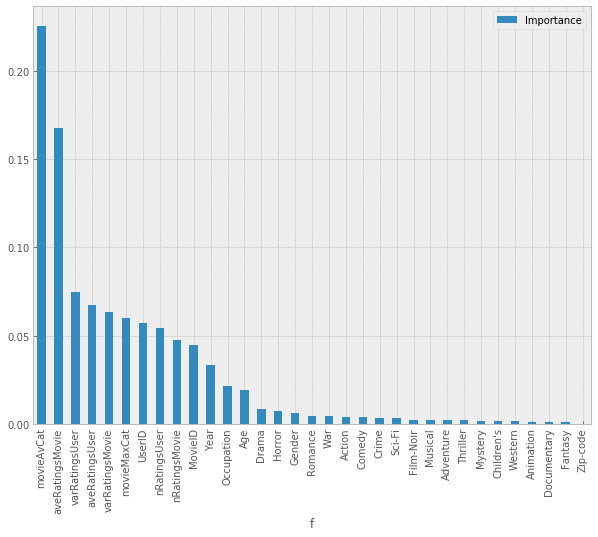

In [4]:
#model = Gradboost
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.style.use('bmh')

cols = np.array(mat.drop('rating',axis=1).columns)

importance = model.feature_importances_

plt.figure()
plt.rcParams["figure.figsize"] = [10,10]
featImport = pd.concat((pd.DataFrame(cols),pd.DataFrame(importance)),axis=1)
featImport.columns=['f','Importance']
featImport.sort_values('Importance',ascending=False,inplace=True)
featImport.set_index('f',inplace=True)

featImport.plot(kind='bar')
plt.subplots_adjust(bottom = 0.3)
plt.show()

# Model evaluation

Our model is evaluated against a baseline that predicts the mean rating for all users. 
Two metrics are then used : 
- mean squared error
- explained variance

The explained variance of our baseline is zero as it predicts a constant for all points of our model. 

In [16]:
print mean_squared_error(y_test,y_pred)
print mean_squared_error(y_test,np.repeat(np.mean(y_test),len(y_test)))
print explained_variance_score(y_test,y_pred)
print explained_variance_score(y_test,np.repeat(np.mean(y_test),len(y_test)))

0.68831539534
1.23948208759
0.444683270192
-2.22044604925e-16


In [31]:
mseMeanList = []
mseModelList = []
explModelVarList = []
for i in range(10):
    y_test, y_pred = shuffle(y_test,y_pred)
    offset = int(y_test.shape[0] * 0.1)
    y_testsub, y_predsub = y_test[:offset], y_pred[:offset]
    mseModelList.append(mean_squared_error(y_testsub,y_predsub))
    mseMeanList.append(mean_squared_error(y_testsub,np.repeat(np.mean(y_testsub),len(y_testsub))))
    explModelVarList.append(explained_variance_score(y_testsub,y_predsub))

results = pd.DataFrame(mseMeanList,columns=['mseMeanList'])
results = results.assign(mseModelList=mseModelList)
results = results.assign(explModelVarList=explModelVarList)

In [32]:
results

,mseMeanList,mseModelList,explModelVarList
0,1.246529,0.703665,0.435524
1,1.221218,0.676718,0.445909
2,1.235756,0.690349,0.441401
3,1.260494,0.694041,0.449392
4,1.219159,0.684551,0.438792
5,1.240084,0.705840,0.430813
6,1.238322,0.687599,0.444778
7,1.220787,0.688520,0.436013
8,1.239683,0.692103,0.441724
9,1.234692,0.702814,0.430779


# Confidence interval

In [33]:
print results.mean()-1.96*np.sqrt(results.var()/10)
print results.mean()+1.96*np.sqrt(results.var()/10)


mseMeanList         1.227722
mseModelList        0.686894
explModelVarList    0.435618
dtype: float64
mseMeanList         1.243622
mseModelList        0.698346
explModelVarList    0.443407
dtype: float64


# Webservice description
The webservice uses our trained model to predict, for a user, which movies would have the best rating and returns the top 20 list. 

Model training is done beforehand, while prediction is done 'on the fly'. 

### Initialization
All the data is loaded in memory, including the trained model. 

### addUser
A user is added to the users list

### addData(user,movie)
A {user,movie} rating is added to the rating list

### predictInterests(user)
Steps : 
- all the movies are listed for this user
- the additional features are calculated for this user (taking into account that some movies haven't been rated)
- the trained model is used to predict ratings for all movies for that particular user
- the top rated movies are returned






## Implementation notes

Python has been used for this pipeline. Performance can be an issue, depending on the service architecture. 
In our case, the prediction could be the bottleneck of the chosen pipeline as it re-calculates the {users,movies} interaction on the whole dataset, at each call. 

To prevent any delay in the service response, several improvements could be done (depending on the actual use of the service) : 
- pre-calculate variable features and store them in a variable (like average rating of movies, users etc)
- update the pre-calculations when new ratings are added
- partially update pre-calculations when new ratings are added and fully update them once every XX minutes
- predict all ratings of 'past users' beforehand (which would require memory or disk space but predictInsterests would just be a retrieval of information) and only make calculations for new users 
- make different predictors for new users and for users with history
- ... 
